# Creating heatmaps with interannual variability between months for temperature, sea-ice, and phytoplankton production! 

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Seasonality and interannual variability in SPECTRA

### Temperature 

In [5]:
temp_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_TEMP*.nc', recursive=True))
ds= xr.open_mfdataset(temp_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

In [ ]:
temp_ds_inter = np.empty([63,12,180,360])
temp_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    temp_ds_inter[i,:,:,:] = ds.TEMP[x[i]:x[i]+12,0,:,:]

In [6]:
temp_ao = np.nanmean(temp_ds_inter[:,:,0,170:180,:], axis=(2,3))
temp_cs = np.nanmean(temp_ds_inter[:,:,0,149:170,0:25], axis = (2,3))
temp_bs = np.nanmean(temp_ds_inter[:,:,0,149:170,25:55], axis = (2,3))
temp_ca = np.nanmean(temp_ds_inter[:,:,0,149:170,55:110], axis = (2,3))
temp_bb = np.nanmean(temp_ds_inter[:,:,0,149:170,110:135], axis = (2,3))
temp_ess = np.nanmean(temp_ds_inter[:,:,0,149:170,325:360], axis = (2,3))
temp_ls = np.nanmean(temp_ds_inter[:,:,0,149:170,270:325], axis = (2,3))
temp_ns = np.nanmean(temp_ds_inter[:,:,0,149:170,155:205], axis = (2,3))
temp_bts =np.nanmean(temp_ds_inter[:,:,0,149:170,205:233], axis = (2,3))
temp_ks = np.nanmean(temp_ds_inter[:,:,0,149:170,233:270], axis = (2,3))

### photoC_total

In [5]:
temp_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_photoC_TOT*.nc', recursive=True))
ds= xr.open_mfdataset(temp_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

In [8]:
ds.photoC_TOT.shape

(756, 15, 180, 360)

In [9]:
photoC_TOT_ds_inter = np.empty([63,12,15,180,360])
photoC_TOT_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    photoC_TOT_ds_inter[i,:,:,:,:] = ds.photoC_TOT[x[i]:x[i]+12,:,:,:]

In [10]:
photoC_TOT_ao = np.nanmean(photoC_TOT_ds_inter[:,:,0,170:180,:], axis=(2,3))
photoC_TOT_cs = np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,0:25], axis = (2,3))
photoC_TOT_bs = np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,25:55], axis = (2,3))
photoC_TOT_ca = np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,55:110], axis = (2,3))
photoC_TOT_bb = np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,110:135], axis = (2,3))
photoC_TOT_ess = np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,325:360], axis = (2,3))
photoC_TOT_ls = np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,270:325], axis = (2,3))
photoC_TOT_ns = np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,155:205], axis = (2,3))
photoC_TOT_bts =np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,205:233], axis = (2,3))
photoC_TOT_ks = np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,233:270], axis = (2,3))

### Sea-ICE

In [11]:
temp_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_ECOSYS_IFRAC*.nc', recursive=True))
ds= xr.open_mfdataset(temp_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

In [12]:
ECOSYS_IFRAC_ds_inter = np.empty([63,12,180,360])
ECOSYS_IFRAC_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    ECOSYS_IFRAC_ds_inter[i,:,:,:] = ds.ECOSYS_IFRAC[x[i]:x[i]+12,:,:]

In [13]:
ECOSYS_IFRAC_ao = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,170:180,:], axis=(2,3))
ECOSYS_IFRAC_cs = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,0:25], axis = (2,3))
ECOSYS_IFRAC_bs = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,25:55], axis = (2,3))
ECOSYS_IFRAC_ca = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,55:110], axis = (2,3))
ECOSYS_IFRAC_bb = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,110:135], axis = (2,3))
ECOSYS_IFRAC_ess = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,325:360], axis = (2,3))
ECOSYS_IFRAC_ls = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,270:325], axis = (2,3))
ECOSYS_IFRAC_ns = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,155:205], axis = (2,3))
ECOSYS_IFRAC_bts =np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,205:233], axis = (2,3))
ECOSYS_IFRAC_ks = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,233:270], axis = (2,3))

## CREATE heatmaps! 

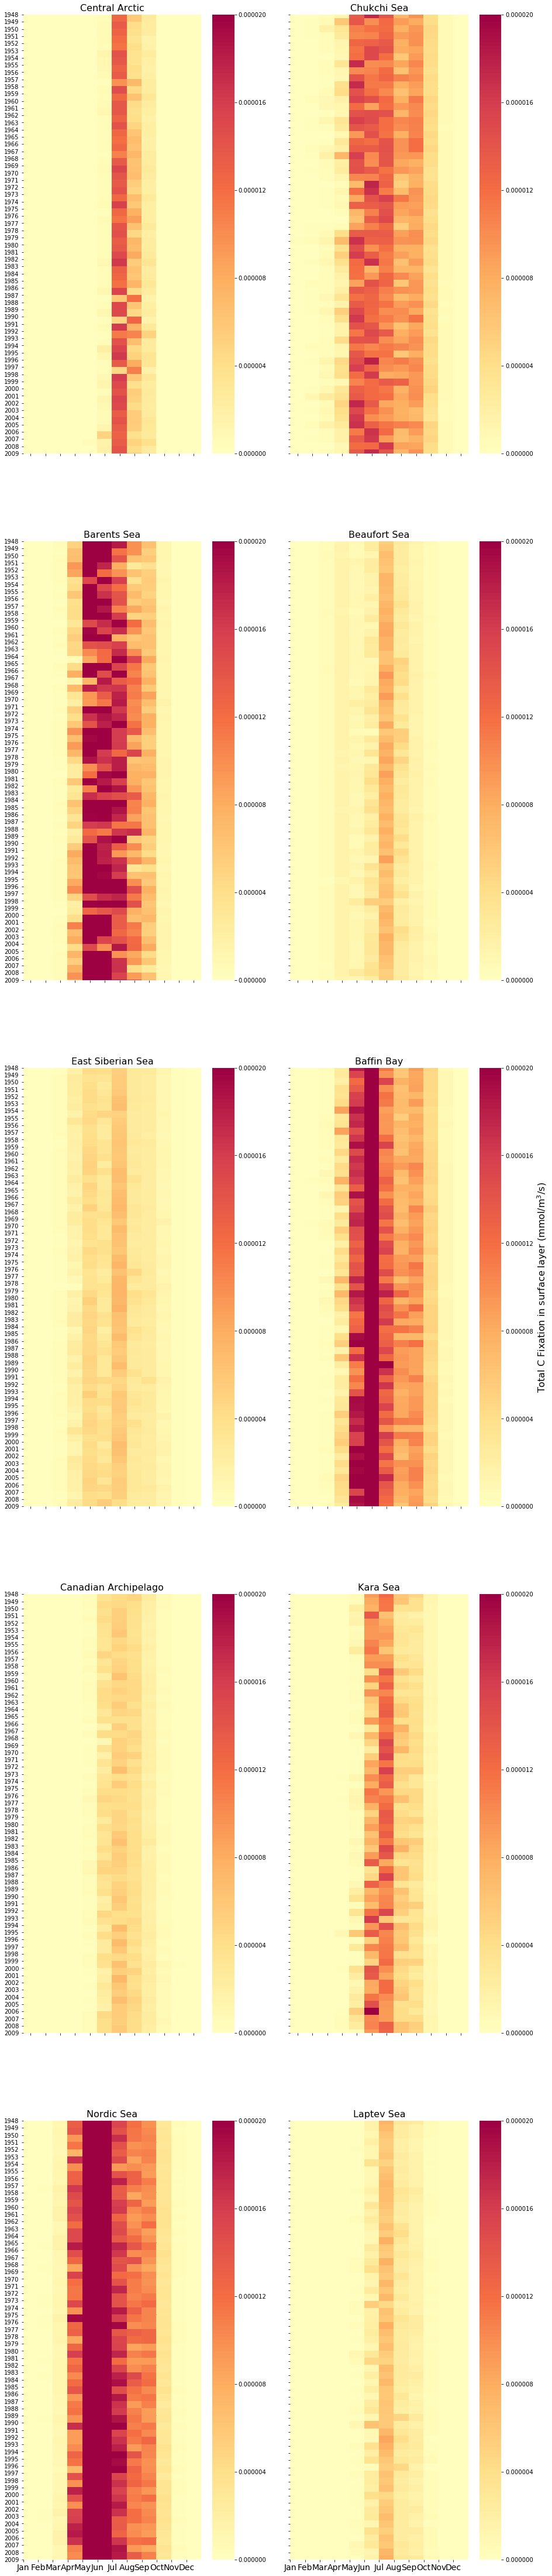

In [14]:
from matplotlib.gridspec import GridSpec
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = ["1948","1949",
         "1950",'1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']
fig = plt.figure(figsize=(15, 80))
gs = GridSpec(nrows=5, ncols=2)



#subplot 1
ax0 = fig.add_subplot(gs[0, 0])
ax= sns.heatmap(photoC_TOT_ao,center=0,cmap="Spectral_r",vmin=0,vmax=0.00002)
ax.set_yticks(np.arange(len(years))); #ax.set_xticks(np.arange(len(months)))
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels('')
ax.set_title('Central Arctic', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar


ax0 = fig.add_subplot(gs[0, 1])
ax= sns.heatmap(photoC_TOT_cs,center=0,cmap="Spectral_r",vmin=0,vmax=0.00002)
#ax.set_yticks(np.arange(len(years))); #ax.set_xticks(np.arange(len(months)))
ax.set_yticklabels(''); ax.set_xticklabels('')
ax.set_title('Chukchi Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar


ax0 = fig.add_subplot(gs[1, 1])
axx2= sns.heatmap(photoC_TOT_bs,center=0,cmap="Spectral_r",vmin=0,vmax=0.00002)
#axx2.set_yticks(np.arange(len(years))); #axx2.set_xticks(np.arange(len(months)))
axx2.set_yticklabels(''); axx2.set_xticklabels('')
axx2.set_title('Beaufort Sea', fontsize=16)
plt.setp(axx2.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = axx2.collections[0].colorbar


ax0 = fig.add_subplot(gs[1, 0])
ax= sns.heatmap(photoC_TOT_bts,center=0,cmap="Spectral_r",vmin=0,vmax=0.00002)
ax.set_yticks(np.arange(len(years))); #ax.set_xticks(np.arange(len(months)))
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels('')
ax.set_title('Barents Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar


ax0 = fig.add_subplot(gs[2, 0])
ax= sns.heatmap(photoC_TOT_ess,center=0,cmap="Spectral_r",vmin=0,vmax=0.00002)
ax.set_yticks(np.arange(len(years))); #ax.set_xticks(np.arange(len(months)))
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels('')
ax.set_title('East Siberian Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar


ax0 = fig.add_subplot(gs[3, 0])
ax= sns.heatmap(photoC_TOT_ca,center=0,cmap="Spectral_r",vmin=0,vmax=0.00002)
ax.set_yticks(np.arange(len(years))); #ax.set_xticks(np.arange(len(months)))
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels('')
ax.set_title('Canadian Archipelago', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar


ax0 = fig.add_subplot(gs[4, 0])
ax= sns.heatmap(photoC_TOT_ns,center=0,cmap="Spectral_r",vmin=0,vmax=0.00002)
ax.set_yticks(np.arange(len(years))); ax.set_xticks(np.arange(len(months)))
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels(months, fontsize=14)
ax.set_title('Nordic Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar


ax0 = fig.add_subplot(gs[3, 1])
ax= sns.heatmap(photoC_TOT_ks,center=0,cmap="Spectral_r",vmin=0,vmax=0.00002)
#ax.set_yticks(np.arange(len(years))); #ax.set_xticks(np.arange(len(months)))
ax.set_yticklabels(''); ax.set_xticklabels('')
ax.set_title('Kara Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar


ax0 = fig.add_subplot(gs[4, 1])
ax= sns.heatmap(photoC_TOT_ls,center=0,cmap="Spectral_r",vmin=0,vmax=0.00002)
#ax.set_yticks(np.arange(len(years))); 
ax.set_xticks(np.arange(len(months)))
ax.set_yticklabels(''); ax.set_xticklabels(months, fontsize=14)
ax.set_title('Laptev Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar


ax0 = fig.add_subplot(gs[2, 1])
ax= sns.heatmap(photoC_TOT_bb,center=0,cmap="Spectral_r",vmin=0,vmax=0.00002)
#ax.set_yticks(np.arange(len(years))); #ax.set_xticks(np.arange(len(months)))
ax.set_yticklabels(''); ax.set_xticklabels('')
ax.set_title('Baffin Bay', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar
cbar.set_label('Total C Fixation in surface layer (mmol/m$^3$/s)', fontsize =16)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/photoC_TOT_interannual_62yr',dpi=600, bbox_inches='tight')

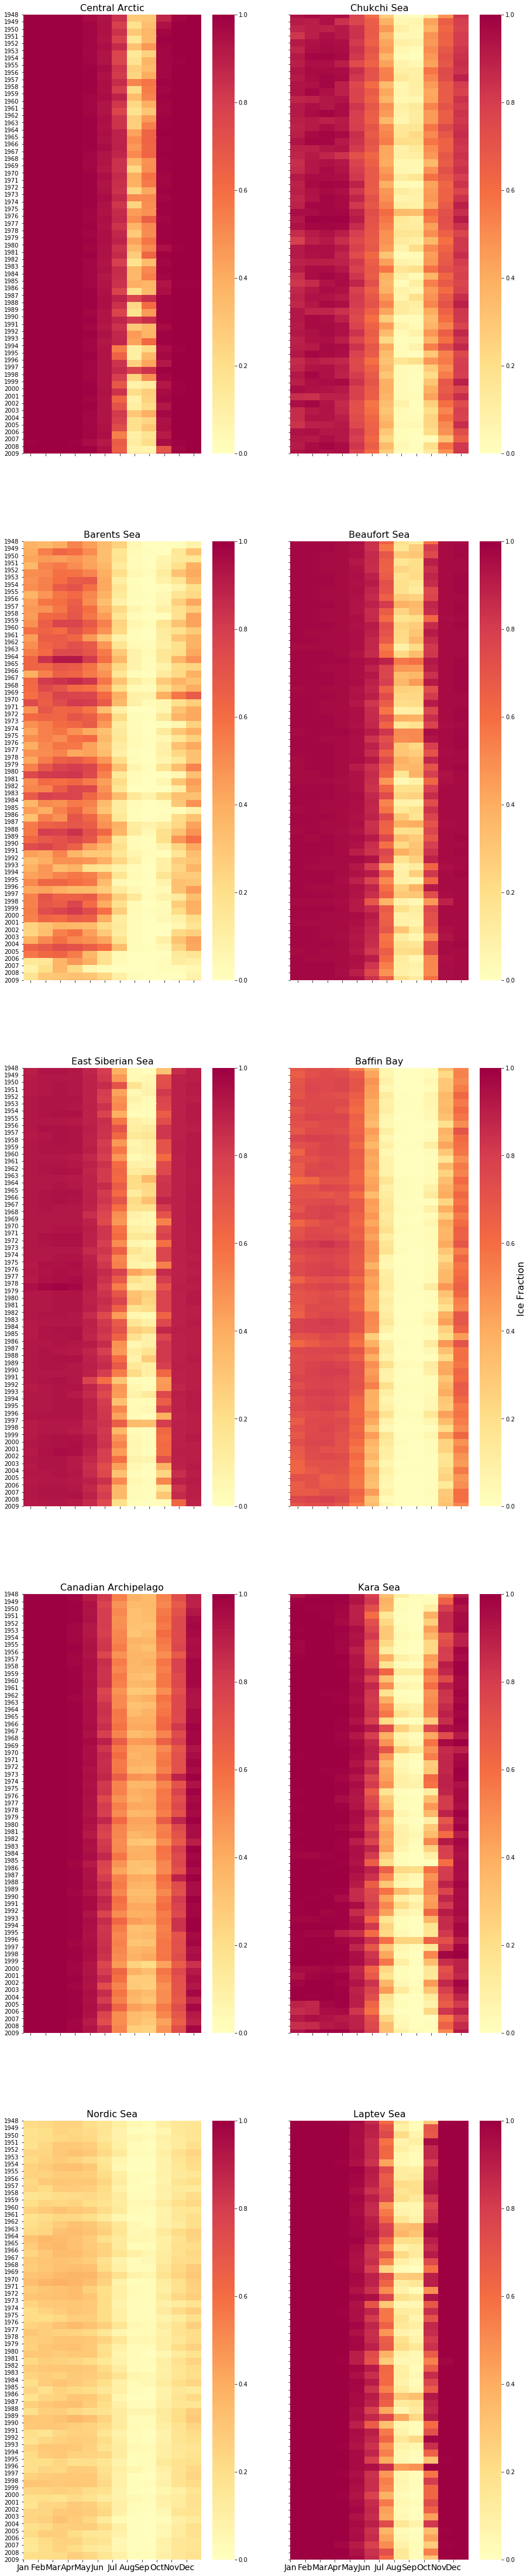

In [15]:
from matplotlib.gridspec import GridSpec
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = ["1948","1949",
         "1950",'1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']
fig = plt.figure(figsize=(15, 80))
gs = GridSpec(nrows=5, ncols=2)


#subplot 1
ax0 = fig.add_subplot(gs[0, 0])
ax= sns.heatmap(ECOSYS_IFRAC_ao,center=0,cmap="Spectral_r",vmin=0,vmax=1)
ax.set_yticks(np.arange(len(years)));
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels('')
ax.set_title('Central Arctic', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[0, 1])
ax= sns.heatmap(ECOSYS_IFRAC_cs,center=0,cmap="Spectral_r",vmin=0,vmax=1)
ax.set_yticklabels(''); ax.set_xticklabels('')
ax.set_title('Chukchi Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[1, 1])
axx2= sns.heatmap(ECOSYS_IFRAC_bs,center=0,cmap="Spectral_r",vmin=0,vmax=1)
axx2.set_yticklabels(''); axx2.set_xticklabels('')
axx2.set_title('Beaufort Sea', fontsize=16)
plt.setp(axx2.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = axx2.collections[0].colorbar

ax0 = fig.add_subplot(gs[1, 0])
ax= sns.heatmap(ECOSYS_IFRAC_bts,center=0,cmap="Spectral_r",vmin=0,vmax=1)
ax.set_yticks(np.arange(len(years)));
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels('')
ax.set_title('Barents Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[2, 0])
ax= sns.heatmap(ECOSYS_IFRAC_ess,center=0,cmap="Spectral_r",vmin=0,vmax=1)
ax.set_yticks(np.arange(len(years)));
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels('')
ax.set_title('East Siberian Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[3, 0])
ax= sns.heatmap(ECOSYS_IFRAC_ca,center=0,cmap="Spectral_r",vmin=0,vmax=1)
ax.set_yticks(np.arange(len(years)));
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels('')
ax.set_title('Canadian Archipelago', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[4, 0])
ax= sns.heatmap(ECOSYS_IFRAC_ns,center=0,cmap="Spectral_r",vmin=0,vmax=1)
ax.set_yticks(np.arange(len(years))); ax.set_xticks(np.arange(len(months)))
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels(months, fontsize=14)
ax.set_title('Nordic Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[3, 1])
ax= sns.heatmap(ECOSYS_IFRAC_ks,center=0,cmap="Spectral_r",vmin=0,vmax=1)
ax.set_yticklabels(''); ax.set_xticklabels('')
ax.set_title('Kara Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[4, 1])
ax= sns.heatmap(ECOSYS_IFRAC_ls,center=0,cmap="Spectral_r",vmin=0,vmax=1)
ax.set_xticks(np.arange(len(months)))
ax.set_yticklabels(''); ax.set_xticklabels(months, fontsize=14)
ax.set_title('Laptev Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[2, 1])
ax= sns.heatmap(ECOSYS_IFRAC_bb,center=0,cmap="Spectral_r",vmin=0,vmax=1)
ax.set_yticklabels(''); ax.set_xticklabels('')
ax.set_title('Baffin Bay', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar
cbar.set_label('Ice Fraction ', fontsize =16)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/ICE_interannual_62yr',dpi=600, bbox_inches='tight')

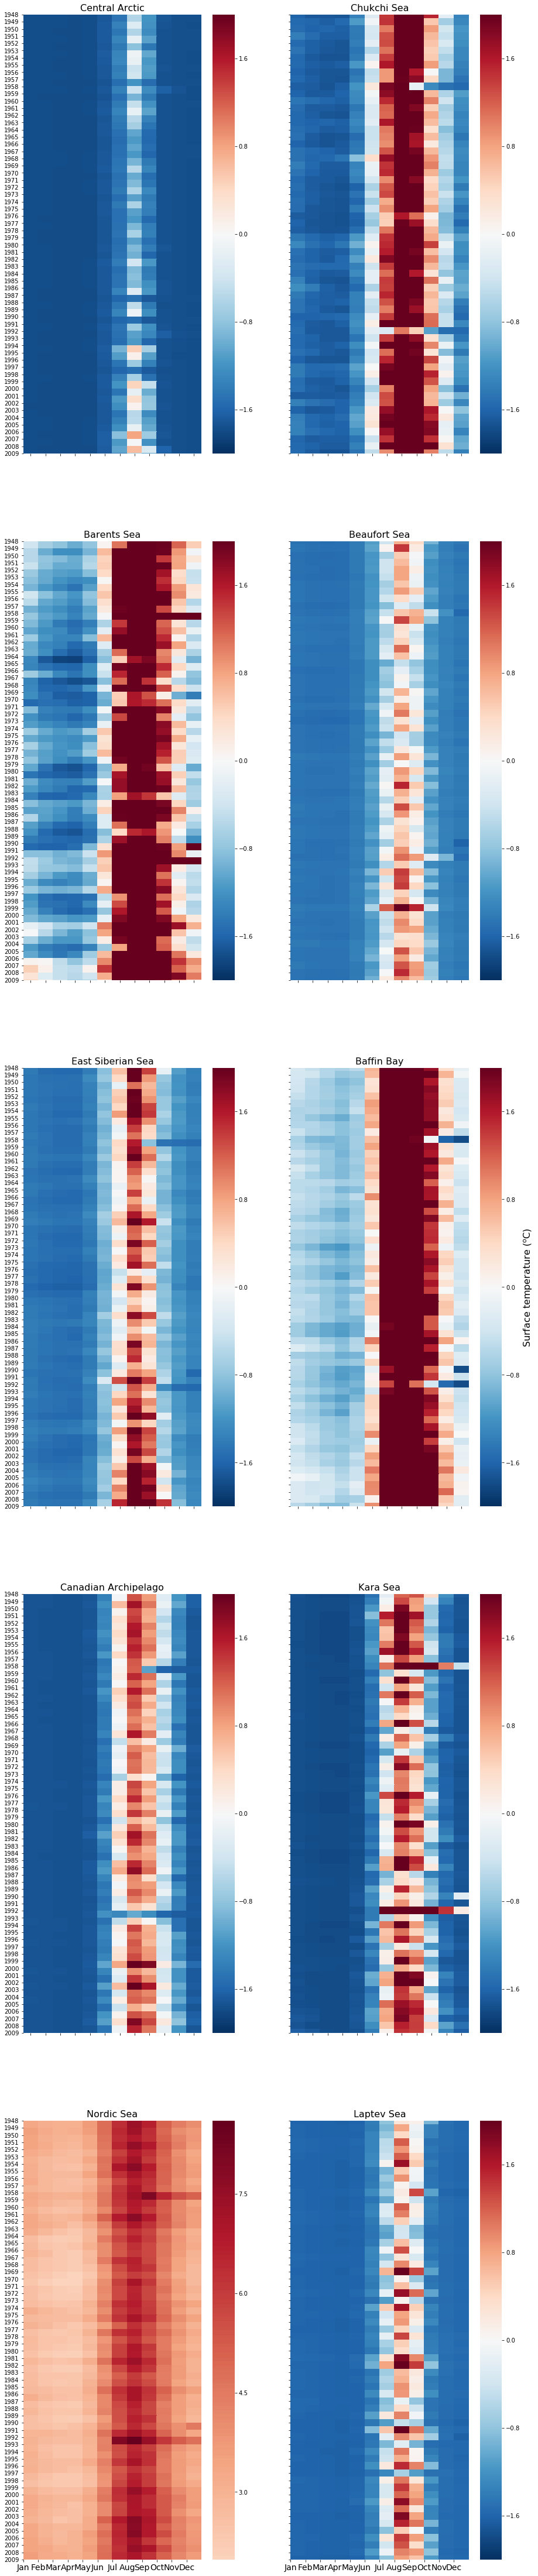

In [13]:
from matplotlib.gridspec import GridSpec
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = ["1948","1949",
         "1950",'1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']
fig = plt.figure(figsize=(15, 80))
gs = GridSpec(nrows=5, ncols=2)


#subplot 1
ax0 = fig.add_subplot(gs[0, 0])
ax= sns.heatmap(temp_ao,center=0,cmap="RdBu_r",vmin=-2,vmax=2)
ax.set_yticks(np.arange(len(years)));
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels('')
ax.set_title('Central Arctic', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[0, 1])
ax= sns.heatmap(temp_cs,center=0,cmap="RdBu_r",vmin=-2,vmax=2)
ax.set_yticklabels(''); ax.set_xticklabels('')
ax.set_title('Chukchi Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[1, 1])
axx2= sns.heatmap(temp_bs,center=0,cmap="RdBu_r",vmin=-2,vmax=2)
axx2.set_yticklabels(''); axx2.set_xticklabels('')
axx2.set_title('Beaufort Sea', fontsize=16)
plt.setp(axx2.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = axx2.collections[0].colorbar

ax0 = fig.add_subplot(gs[1, 0])
ax= sns.heatmap(temp_bts,center=0,cmap="RdBu_r",vmin=-2,vmax=2)
ax.set_yticks(np.arange(len(years)));
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels('')
ax.set_title('Barents Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[2, 0])
ax= sns.heatmap(temp_ess,center=0,cmap="RdBu_r",vmin=-2,vmax=2)
ax.set_yticks(np.arange(len(years)));
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels('')
ax.set_title('East Siberian Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[3, 0])
ax= sns.heatmap(temp_ca,center=0,cmap="RdBu_r",vmin=-2,vmax=2)
ax.set_yticks(np.arange(len(years)));
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels('')
ax.set_title('Canadian Archipelago', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[4, 0])
ax= sns.heatmap(temp_ns,center=0,cmap="RdBu_r")
ax.set_yticks(np.arange(len(years))); ax.set_xticks(np.arange(len(months)))
ax.set_yticklabels(years, fontsize=10); ax.set_xticklabels(months, fontsize=14)
ax.set_title('Nordic Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[3, 1])
ax= sns.heatmap(temp_ks,center=0,cmap="RdBu_r",vmin=-2,vmax=2)
ax.set_yticklabels(''); ax.set_xticklabels('')
ax.set_title('Kara Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[4, 1])
ax= sns.heatmap(temp_ls,center=0,cmap="RdBu_r",vmin=-2,vmax=2)
ax.set_xticks(np.arange(len(months)))
ax.set_yticklabels(''); ax.set_xticklabels(months, fontsize=14)
ax.set_title('Laptev Sea', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar

ax0 = fig.add_subplot(gs[2, 1])
ax= sns.heatmap(temp_bb,center=0,cmap="RdBu_r",vmin=-2,vmax=2)
ax.set_yticklabels(''); ax.set_xticklabels('')
ax.set_title('Baffin Bay', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
cbar = ax.collections[0].colorbar
cbar.set_label('Surface temperature ($^o$C) ', fontsize =16)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/temperature_interannual_62yr',dpi=600, bbox_inches='tight')